In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

#Preprocess the Dataset

In [2]:
# Disable oneDNN optimizations to prevent OpenMP conflict
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Define paths
base_dir = r'C:\Users\nayer\pneumonia-detection\data\chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Data generators with augmentation and validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.9, 1.1],
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training'
)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#Build the ResNet50 Model

In [4]:
# Load ResNet50 with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

94765736/94765736 [==============================] - 127s 1us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


#Train with Frozen Layers

In [5]:
# Train the model (frozen base)
history_tl = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/10
131/131 [==============================] - 896s 7s/step - loss: 0.5393 - accuracy: 0.7457 - val_loss: 0.4977 - val_accuracy: 0.7440
Epoch 2/10
131/131 [==============================] - 575s 4s/step - loss: 0.4753 - accuracy: 0.7697 - val_loss: 0.4861 - val_accuracy: 0.7728
Epoch 3/10
131/131 [==============================] - 1017s 8s/step - loss: 0.4336 - accuracy: 0.7922 - val_loss: 0.4816 - val_accuracy: 0.7641
Epoch 4/10
131/131 [==============================] - 1755s 13s/step - loss: 0.4228 - accuracy: 0.7942 - val_loss: 0.5389 - val_accuracy: 0.7402
Epoch 5/10
131/131 [==============================] - 2505s 19s/step - loss: 0.4038 - accuracy: 0.8035 - val_loss: 0.5140 - val_accuracy: 0.7574
Epoch 6/10
131/131 [==============================] - 582s 4s/step - loss: 0.3934 - accuracy: 0.8121 - val_loss: 0.3802 - val_accuracy: 0.8063
Epoch 7/10
131/131 [==============================] - 588s 4s/step - loss: 0.3786 - accuracy: 0.8243 - val_loss: 0.3616 - val_accuracy: 0

#Fine-Tune the Model

In [6]:
# Unfreeze the last 10 layers of ResNet50
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Recompile with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Fine-tune
history_ft = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

# Save the model
model.save(r'C:\Users\nayer\pneumonia-detection\models\resnet50_finetuned.h5')

Epoch 1/10
131/131 [==============================] - 1020s 8s/step - loss: 0.3249 - accuracy: 0.8687 - val_loss: 0.5020 - val_accuracy: 0.8217
Epoch 2/10
131/131 [==============================] - 1529s 12s/step - loss: 0.2269 - accuracy: 0.9068 - val_loss: 0.3073 - val_accuracy: 0.8869
Epoch 3/10
131/131 [==============================] - 1762s 14s/step - loss: 0.2182 - accuracy: 0.9087 - val_loss: 0.2767 - val_accuracy: 0.8619
Epoch 4/10
131/131 [==============================] - 586s 4s/step - loss: 0.2060 - accuracy: 0.9118 - val_loss: 4.8071 - val_accuracy: 0.7430
Epoch 5/10
131/131 [==============================] - 589s 4s/step - loss: 0.2013 - accuracy: 0.9140 - val_loss: 0.7805 - val_accuracy: 0.7498
Epoch 6/10
131/131 [==============================] - 600s 5s/step - loss: 0.1997 - accuracy: 0.9185 - val_loss: 1.2304 - val_accuracy: 0.5235


#Evaluate and Compare

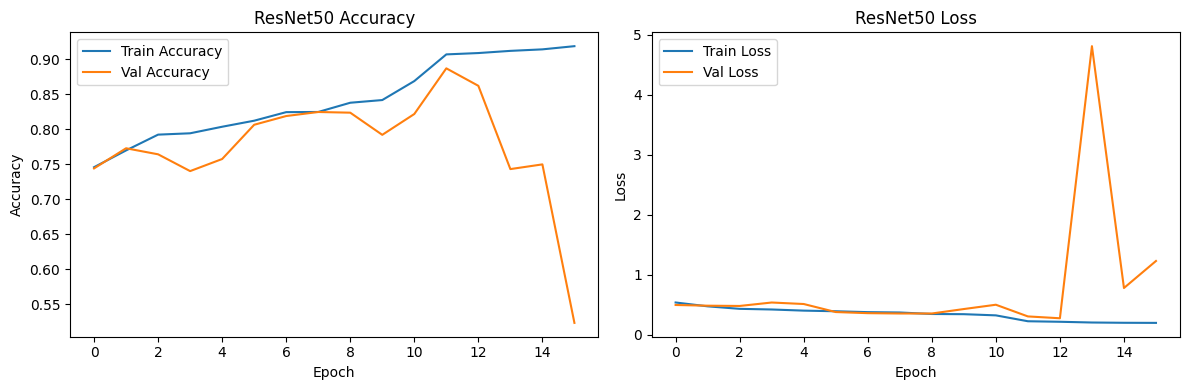

20/20 [==============================] - 65s 3s/step - loss: 0.6254 - accuracy: 0.7212
Test Accuracy: 0.7212
20/20 [==============================] - 89s 4s/step
Confusion Matrix:
 [[ 61 173]
 [  1 389]]
Classification Report:
               precision    recall  f1-score   support

      Normal       0.98      0.26      0.41       234
   Pneumonia       0.69      1.00      0.82       390

    accuracy                           0.72       624
   macro avg       0.84      0.63      0.61       624
weighted avg       0.80      0.72      0.67       624



<Figure size 640x480 with 0 Axes>

In [8]:
# Plot accuracy and loss (combine transfer learning and fine-tuning)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['accuracy'] + history_ft.history['accuracy'], label='Train Accuracy')
plt.plot(history_tl.history['val_accuracy'] + history_ft.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tl.history['loss'] + history_ft.history['loss'], label='Train Loss')
plt.plot(history_tl.history['val_loss'] + history_ft.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Save plot
plt.savefig(r'C:\Users\nayer\pneumonia-detection\docs\resnet50_plot.png')

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test Accuracy: {test_acc:.4f}')

# Confusion matrix and classification report
test_generator.reset()
y_pred = (model.predict(test_generator) > 0.5).astype(int)
y_true = test_generator.classes
cm = confusion_matrix(y_true, y_pred)
print('Confusion Matrix:\n', cm)
print('Classification Report:\n', classification_report(y_true, y_pred, target_names=['Normal', 'Pneumonia']))